In [ ]:
!pip install ucimlrepo

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
# ============================================================================
# STEP 0: IMPORTS, SETTINGS & INSTALL NOTES
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

# Standard libs
import numpy as np
import pandas as pd
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder # Preprocessing
from sklearn.cluster import KMeans, DBSCAN # Clustring
from sklearn.decomposition import PCA # Dimension reduce
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold  # Model selection
from sklearn.linear_model import LogisticRegression # Linear Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier # Ensemble Models
from sklearn.metrics import roc_auc_score, silhouette_score # Metrics
from sklearn.feature_selection import SelectKBest, f_classif, RFE # Feature Selection
from sklearn.mixture import GaussianMixture # GMM
from imblearn.over_sampling import SMOTE # Imbalance
from sklearn.impute import SimpleImputer

# Optional libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# Utility to display sections clearly
def show_header(title):
    print('\n' + '=' * 80)
    print(title)
    print('=' * 80 + '\n')

In [ ]:
# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================

show_header('STEP 1: DATA LOADING')

from ucimlrepo import fetch_ucirepo
print('Attempting to fetch dataset via ucimlrepo.fetch_ucirepo(id=222) ...')
bank_marketing = fetch_ucirepo(id=222)
X_original = bank_marketing.data.features
y_original = bank_marketing.data.targets
df = X_original.copy()
# target column may be a DataFrame with single column
df['y'] = y_original.iloc[:, 0]
print('Dataset loaded via ucimlrepo.')





STEP 1: DATA LOADING

Attempting to fetch dataset via ucimlrepo.fetch_ucirepo(id=222) ...
Dataset loaded via ucimlrepo.


In [ ]:
# Normalize the target to binary 0/1 if necessary
if df['y'].dtype == 'object' or df['y'].dtype == 'bool':
    df['y'] = (df['y'] == 'yes').astype(int)

print(f"Dataset Shape: {df.shape}")
print(f"Response Rate: {df['y'].mean():.2%}")
print('\nColumns:\n', df.columns.tolist())

Dataset Shape: (45211, 17)
Response Rate: 11.70%

Columns:
 ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [ ]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN,0


In [ ]:
show_header('STEP 2: FEATURE ENGINEERING')

# Work on a copy
df_enhanced = df.copy()

# --- Create boolean flags for housing/loan BEFORE encoding ---
for col in ['housing', 'loan']:
    if col in df_enhanced.columns:
        df_enhanced[f'{col}_flag'] = (df_enhanced[col].astype(str).str.lower() == 'yes').astype(int)


STEP 2: FEATURE ENGINEERING



In [ ]:
df_enhanced

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,housing_flag,loan_flag
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,0,1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,0,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,0,1,1
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,0,1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN,1,0,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN,1,0,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1,0,0
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN,0,0,0


In [ ]:
# 1) Temporal features: month -> numeric, cyclical encoding, weekday
month_mapping = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
if 'month' in df_enhanced.columns:
    df_enhanced['month_num'] = df_enhanced['month'].map(month_mapping)
    # Handle missing months
    df_enhanced['month_num'] = df_enhanced['month_num'].fillna(0).astype(int)

df_enhanced['approx_date'] = (df_enhanced['month_num'] - 1) * 31 + df_enhanced['day_of_week']



In [ ]:
# prev_success_rate: use poutcome == 'success' but only where previous > 0
if 'previous' in df_enhanced.columns and 'poutcome' in df_enhanced.columns:
    df_enhanced['prev_success_rate'] = np.where(df_enhanced['previous'] > 0,
                                                (df_enhanced['poutcome'].astype(str).str.lower() == 'success').astype(int),
                                                0)

In [ ]:
# duration buckets and engagement score
if 'duration' in df_enhanced.columns:
    duration_q = df_enhanced['duration'].quantile([0.25,0.5,0.75]).to_list()
    # Ensure unique and sorted
    bins = [0] + duration_q + [df_enhanced['duration'].max()+1]
    df_enhanced['duration_bucket'] = pd.cut(df_enhanced['duration'], bins=bins, labels=['Short','Medium','Long','Very_Long'], include_lowest=True)

    # engagement score (normalize duration)
    dur_max = df_enhanced['duration'].max()
    df_enhanced['engagement_score'] = (
        (df_enhanced['duration'] / dur_max) * 0.4 +
        (1 / (df_enhanced.get('campaign', 0) + 1)) * 0.3 +
        df_enhanced['prev_success_rate'] * 0.3
    )

In [ ]:
df_enhanced

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,previous,poutcome,y,housing_flag,loan_flag,month_num,approx_date,prev_success_rate,duration_bucket,engagement_score
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,...,0,NaN,0,1,0,5,129,0,Long,0.171228
1,44,technician,single,secondary,no,29,yes,no,NaN,5,...,0,NaN,0,1,0,5,129,0,Medium,0.162281
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,...,0,NaN,0,1,1,5,129,0,Short,0.156181
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,...,0,NaN,0,1,0,5,129,0,Short,0.157483
4,33,NaN,single,NaN,no,1,no,no,NaN,5,...,0,NaN,0,0,0,5,129,0,Long,0.166104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,0,NaN,1,0,0,11,327,0,Very_Long,0.154463
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,0,NaN,1,0,0,11,327,0,Very_Long,0.137088
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,3,success,1,0,0,11,327,1,Very_Long,0.441663
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,0,NaN,0,0,0,11,327,0,Very_Long,0.101318


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
kbe = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
# KBinsDiscretizer expects 2D array

df_enhanced['balance_bin_kmeans'] = kbe.fit_transform(df_enhanced[['balance']]).astype(int).ravel()


In [ ]:
kbe.bin_edges_

array([array([ -8019.        ,   1904.87254418,   6272.86068159,  15626.87780957,
               39965.37944884, 102127.        ])                                 ],
      dtype=object)

In [ ]:
# 3) Demographic interactions
if 'age' in df_enhanced.columns:
    df_enhanced['age_group_detailed'] = pd.cut(df_enhanced['age'], bins=[0,25,35,45,55,65,100], labels=['18-25','26-35','36-45','46-55','56-65','65+'])


In [ ]:
df_enhanced

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,y,housing_flag,loan_flag,month_num,approx_date,prev_success_rate,duration_bucket,engagement_score,balance_bin_kmeans,age_group_detailed
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,...,0,1,0,5,129,0,Long,0.171228,1,56-65
1,44,technician,single,secondary,no,29,yes,no,NaN,5,...,0,1,0,5,129,0,Medium,0.162281,0,36-45
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,...,0,1,1,5,129,0,Short,0.156181,0,26-35
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,...,0,1,0,5,129,0,Short,0.157483,0,46-55
4,33,NaN,single,NaN,no,1,no,no,NaN,5,...,0,0,0,5,129,0,Long,0.166104,0,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,1,0,0,11,327,0,Very_Long,0.154463,0,46-55
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,1,0,0,11,327,0,Very_Long,0.137088,0,65+
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,1,0,0,11,327,1,Very_Long,0.441663,1,65+
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,0,0,0,11,327,0,Very_Long,0.101318,0,56-65


In [ ]:
print('Feature engineering completed. New columns added:')
new_cols = [c for c in df_enhanced.columns if c not in df.columns]
print(new_cols)

Feature engineering completed. New columns added:
['housing_flag', 'loan_flag', 'month_num', 'approx_date', 'prev_success_rate', 'duration_bucket', 'engagement_score', 'balance_bin_kmeans', 'age_group_detailed']


In [ ]:
df_proc = df_enhanced.copy()
df_proc.isnull().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


In [ ]:
for col in ['job', 'education','contact']:
    if col in df_proc.columns:
        imputer = SimpleImputer(strategy='most_frequent')
        df_proc[[col]] = imputer.fit_transform(df_proc[[col]])
        print(f"Missing values in '{col}' filled with most frequent value: {imputer.statistics_[0]}")

Missing values in 'job' filled with most frequent value: blue-collar
Missing values in 'education' filled with most frequent value: secondary
Missing values in 'contact' filled with most frequent value: cellular


In [ ]:
df_proc.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day_of_week,0


In [ ]:
df_proc

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,y,housing_flag,loan_flag,month_num,approx_date,prev_success_rate,duration_bucket,engagement_score,balance_bin_kmeans,age_group_detailed
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,...,0,1,0,5,129,0,Long,0.171228,1,56-65
1,44,technician,single,secondary,no,29,yes,no,cellular,5,...,0,1,0,5,129,0,Medium,0.162281,0,36-45
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,...,0,1,1,5,129,0,Short,0.156181,0,26-35
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,...,0,1,0,5,129,0,Short,0.157483,0,46-55
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,...,0,0,0,5,129,0,Long,0.166104,0,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,1,0,0,11,327,0,Very_Long,0.154463,0,46-55
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,1,0,0,11,327,0,Very_Long,0.137088,0,65+
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,1,0,0,11,327,1,Very_Long,0.441663,1,65+
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,0,0,0,11,327,0,Very_Long,0.101318,0,56-65


In [ ]:
df_proc['balance'].describe()

,balance
count,45211.000000
mean,1362.272058
std,3044.765829
min,-8019.000000
25%,72.000000
50%,448.000000
75%,1428.000000
max,102127.000000


In [ ]:
cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns.tolist()
# exclude target if present
if 'y' in cat_cols:
    cat_cols.remove('y')

print('Categorical columns to encode:', cat_cols)

Categorical columns to encode: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'duration_bucket', 'age_group_detailed']


In [ ]:
# ============================================================================
# STEP 3 (continued): ENCODING JOB, MARITAL, EDUCATION, CONTACT
# ============================================================================

from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import OrdinalEncoder

# --- Binary Encoding for 'job' and 'marital' ---
binary_cols = ['job', 'marital']
binary_cols = [c for c in binary_cols if c in df_proc.columns]  # safety check
if binary_cols:
    be = BinaryEncoder(cols=binary_cols, drop_invariant=False)
    # <--- replace this single line:
    # df_proc = be.fit_transform(df_proc)
    # with these two minimal lines:
    df_binary = be.fit_transform(df_proc[binary_cols])
    df_proc = pd.concat([df_proc, df_binary], axis=1)

    print(f"Applied Binary Encoding to: {binary_cols}")


# --- Ordinal Encoding for 'education' ---
# Define the logical order of education levels
education_order = [['unknown', 'primary', 'secondary', 'tertiary']]

if 'education' in df_proc.columns:
    oe = OrdinalEncoder(categories=education_order, dtype=int)
    df_proc['education'] = df_proc['education'].fillna('unknown').astype(str)
    df_proc['education_encoded'] = oe.fit_transform(df_proc[['education']])
    print("Applied Ordinal Encoding to 'education' with defined hierarchy.")
else:
    print("'education' column not found — skipped ordinal encoding.")

if 'age_group_detailed' in df_proc.columns:
    # Define logical order of age groups
    age_order = [['18-25', '26-35', '36-45', '46-55', '56-65', '65+']]

    oe_age = OrdinalEncoder(categories=age_order, dtype=int)
    df_proc['age_group_detailed'] = df_proc['age_group_detailed'].astype(str).fillna('18-25')

    df_proc['age_group_encoded'] = oe_age.fit_transform(df_proc[['age_group_detailed']])

    print("Applied Ordinal Encoding to 'age_group_detailed' (age_group_encoded column added).")


# --- Manual binary encoding for 'contact' ---
if 'contact' in df_proc.columns:
    df_proc['contact_binary'] = df_proc['contact'].astype(str).str.lower().map({'cellular': 1, 'telephone': 0})
    df_proc['contact_binary'] = df_proc['contact_binary'].fillna(0).astype(int)
    print("Encoded 'contact' column: cellular → 1, telephone → 0")
else:
    print("'contact' column not found — skipped binary mapping.")


Applied Binary Encoding to: ['job', 'marital']
Applied Ordinal Encoding to 'education' with defined hierarchy.
Applied Ordinal Encoding to 'age_group_detailed' (age_group_encoded column added).
Encoded 'contact' column: cellular → 1, telephone → 0


In [ ]:
df_proc

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,age_group_detailed,job_0,job_1,job_2,job_3,marital_0,marital_1,education_encoded,age_group_encoded,contact_binary
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,...,56-65,0,0,0,1,0,1,3,4,1
1,44,technician,single,secondary,no,29,yes,no,cellular,5,...,36-45,0,0,1,0,1,0,2,2,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,...,26-35,0,0,1,1,0,1,2,1,1
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,...,46-55,0,1,0,0,0,1,2,3,1
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,...,26-35,0,1,0,0,1,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,46-55,0,0,1,0,0,1,3,3,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,65+,0,1,0,1,1,1,1,5,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,65+,0,1,0,1,0,1,2,5,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,56-65,0,1,0,0,0,1,2,4,0


In [ ]:
df_proc.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'housing_flag', 'loan_flag',
       'month_num', 'approx_date', 'prev_success_rate', 'duration_bucket',
       'engagement_score', 'balance_bin_kmeans', 'age_group_detailed', 'job_0',
       'job_1', 'job_2', 'job_3', 'marital_0', 'marital_1',
       'education_encoded', 'age_group_encoded', 'contact_binary'],
      dtype='object')

In [ ]:
df_final = df_proc[['age_group_encoded','job_0','job_1','job_2', 'job_3','marital_0',
       'marital_1','education_encoded','balance_bin_kmeans','housing_flag', 'loan_flag','contact_binary','approx_date','engagement_score','y']]

In [ ]:
df_final

,age_group_encoded,job_0,job_1,job_2,job_3,marital_0,marital_1,education_encoded,balance_bin_kmeans,housing_flag,loan_flag,contact_binary,approx_date,engagement_score,y
0,4,0,0,0,1,0,1,3,1,1,0,1,129,0.171228,0
1,2,0,0,1,0,1,0,2,0,1,0,1,129,0.162281,0
2,1,0,0,1,1,0,1,2,0,1,1,1,129,0.156181,0
3,3,0,1,0,0,0,1,2,0,1,0,1,129,0.157483,0
4,1,0,1,0,0,1,0,2,0,0,0,1,129,0.166104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,3,0,0,1,0,0,1,3,0,0,0,1,327,0.154463,1
45207,5,0,1,0,1,1,1,1,0,0,0,1,327,0.137088,1
45208,5,0,1,0,1,0,1,2,1,0,0,1,327,0.441663,1
45209,4,0,1,0,0,0,1,2,0,0,0,0,327,0.101318,0


In [ ]:
X_enhanced = df_final.drop(columns=['y'])
y = df_proc['y']

print('Prepared X and y:')
print('X shape:', X_enhanced.shape)
print('y distribution:\n', y.value_counts(normalize=True))

Prepared X and y:
X shape: (45211, 14)
y distribution:
 y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


In [ ]:
# Candidate features for clustering (mix of demographics + behavior)
clustering_features = [
    'age_group_encoded','job_0','job_1','job_2', 'job_3','marital_0',
       'marital_1','education_encoded','balance_bin_kmeans','housing_flag', 'loan_flag','contact_binary','approx_date','engagement_score'
]

# Keep only available features
available_features = [f for f in clustering_features if f in X_enhanced.columns]
print(f'Selected clustering features ({len(available_features)}):', available_features)

Selected clustering features (14): ['age_group_encoded', 'job_0', 'job_1', 'job_2', 'job_3', 'marital_0', 'marital_1', 'education_encoded', 'balance_bin_kmeans', 'housing_flag', 'loan_flag', 'contact_binary', 'approx_date', 'engagement_score']


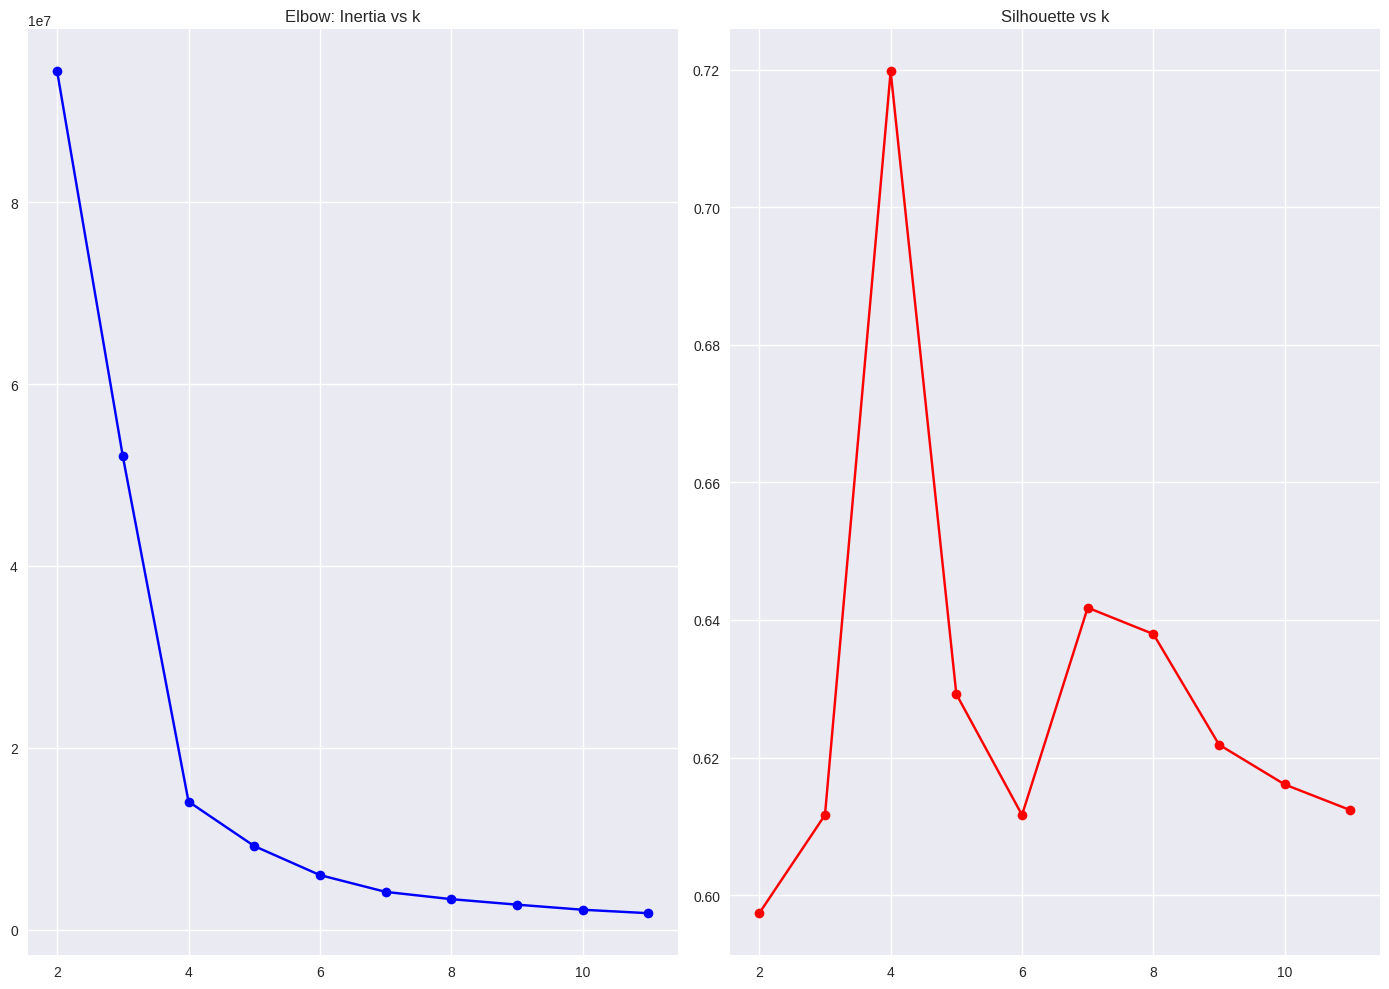

In [ ]:
# If no clustering features available, skip clustering
if len(available_features) == 0:
    print('No clustering features available; skipping clustering step.')
else:
    X_cluster = X_enhanced[available_features].copy()

    # Determine optimal k via multiple metrics
    K_range = range(2, 12)
    metrics_results = {'k': [], 'inertia': [], 'silhouette': []}

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_k = kmeans.fit_predict(X_cluster)
        metrics_results['k'].append(k)
        metrics_results['inertia'].append(kmeans.inertia_)
        # Some metrics require at least 2 clusters; safe-guard
        try:
            metrics_results['silhouette'].append(silhouette_score(X_cluster, labels_k))
        except Exception:
            metrics_results['silhouette'].append(np.nan)

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 10))
    axes = axes.ravel()
    axes[0].plot(metrics_results['k'], metrics_results['inertia'], 'bo-')
    axes[0].set_title('Elbow: Inertia vs k')
    axes[1].plot(metrics_results['k'], metrics_results['silhouette'], 'ro-')
    axes[1].set_title('Silhouette vs k')
    plt.tight_layout()
    plt.show()

In [ ]:
optimal_k = K_range[int(np.nanargmax(metrics_results['silhouette']))]
print('Selected k (by silhouette fallback):', optimal_k)

Selected k (by silhouette fallback): 4


In [ ]:
 # Apply different clustering algorithms
clustering_results = {}

# KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_cluster)
clustering_results['KMeans'] = {'labels': labels_km, 'model': kmeans, 'silhouette': silhouette_score(X_cluster, labels_km)}

In [ ]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
labels_gmm = gmm.fit_predict(X_cluster)
clustering_results['GMM'] = {'labels': labels_gmm, 'model': gmm, 'silhouette': silhouette_score(X_cluster, labels_gmm)}

In [ ]:
# Choose best clustering by silhouette
best_clust_name = max(clustering_results.keys(), key=lambda x: clustering_results[x]['silhouette'])
final_labels = clustering_results[best_clust_name]['labels']
print('Best clustering method:', best_clust_name)
print('Final silhouette score:', clustering_results[best_clust_name]['silhouette'])

Best clustering method: KMeans
Final silhouette score: 0.7197663275687207


In [ ]:
df_final['cluster'] = final_labels
X_enhanced['cluster'] = final_labels

In [ ]:
unique_clusters = sorted([c for c in set(final_labels) if c != -1])
cluster_stats = []
for cid in unique_clusters:
    mask = (final_labels == cid)
    cdata = df_final[mask]
    stats = {
        'Cluster': cid,
        'Size': len(cdata),
        'Size_Pct': len(cdata) / len(df_final) * 100,
        'Response_Rate': cdata['y'].mean(),
    }
    cluster_stats.append(stats)

cluster_df = pd.DataFrame(cluster_stats)

In [ ]:
cluster_df

,Cluster,Size,Size_Pct,Response_Rate
0,0,21890,48.417421,0.092691
1,1,4484,9.917940,0.181534
2,2,13844,30.620867,0.115212
3,3,4993,11.043773,0.170439


In [ ]:
cluster_summary = df_final.groupby('cluster')[clustering_features].mean()
cluster_summary

,age_group_encoded,job_0,job_1,job_2,job_3,marital_0,marital_1,education_encoded,balance_bin_kmeans,housing_flag,loan_flag,contact_binary,approx_date,engagement_score
cluster,,,,,,,,,,,,,,
0,1.938054,0.093102,0.565646,0.448744,0.383508,0.411329,0.705939,2.055368,0.224943,0.745363,0.137825,0.966377,141.666332,0.135836
1,2.066459,0.173506,0.418599,0.453390,0.512043,0.476137,0.637600,2.218778,0.215433,0.390277,0.139831,0.898974,37.833185,0.152444
2,2.139844,0.113118,0.391578,0.473707,0.458466,0.359434,0.750795,2.213667,0.212294,0.334224,0.202615,0.916065,219.304536,0.121231
3,2.195874,0.135790,0.386341,0.435209,0.513919,0.376928,0.744042,2.260164,0.476667,0.488083,0.159223,0.888844,324.113158,0.160851


In [ ]:
df_final

,age_group_encoded,job_0,job_1,job_2,job_3,marital_0,marital_1,education_encoded,balance_bin_kmeans,housing_flag,loan_flag,contact_binary,approx_date,engagement_score,y,cluster
0,4,0,0,0,1,0,1,3,1,1,0,1,129,0.171228,0,0
1,2,0,0,1,0,1,0,2,0,1,0,1,129,0.162281,0,0
2,1,0,0,1,1,0,1,2,0,1,1,1,129,0.156181,0,0
3,3,0,1,0,0,0,1,2,0,1,0,1,129,0.157483,0,0
4,1,0,1,0,0,1,0,2,0,0,0,1,129,0.166104,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,3,0,0,1,0,0,1,3,0,0,0,1,327,0.154463,1,3
45207,5,0,1,0,1,1,1,1,0,0,0,1,327,0.137088,1,3
45208,5,0,1,0,1,0,1,2,1,0,0,1,327,0.441663,1,3
45209,4,0,1,0,0,0,1,2,0,0,0,0,327,0.101318,0,3


In [ ]:
# ============================================================================
# STEP 5: FEATURE SELECTION & TRAIN/TEST SPLIT
# ============================================================================

show_header('STEP 5: FEATURE SELECTION & TRAIN/TEST SPLIT')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)
print('Train/Test shapes:', X_train.shape, X_test.shape)


STEP 5: FEATURE SELECTION & TRAIN/TEST SPLIT

Train/Test shapes: (36168, 15) (9043, 15)


In [ ]:
# Address class imbalance with SMOTE on training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print('After SMOTE, class distribution:', np.bincount(y_train_balanced))

After SMOTE, class distribution: [31937 31937]


In [ ]:
# ============================================================================
# STEP 6: MODEL TUNING & TRAINING
# ============================================================================

show_header('STEP 6: MODEL TUNING & TRAINING')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_to_tune = {
    'LogisticRegression': {                                                                         # LogisticRegression
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {'C':[0.1,1.0,10.0], 'penalty':['l1','l2'], 'solver':['liblinear']}
    },
    'RandomForest': {                                                                               # RandomForest
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators':[100,200], 'max_depth':[10,20,None], 'min_samples_split':[5,10]}
    },
    'GradientBoosting': {                                                                           # GradientBoosting
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators':[100,200], 'max_depth':[5,10], 'learning_rate':[0.1,0.2]}
    },
    'xgboost': {                                                                                    # Xgboost
        'model': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators':[100,200], 'max_depth':[6,10], 'learning_rate':[0.1,0.2]}}                                                                                  # xgboost
}


STEP 6: MODEL TUNING & TRAINING



In [ ]:
best_models = {}

for name, cfg in models_to_tune.items():
    print(f'\nTuning {name} ...')
    model = cfg['model']
    params = cfg['params']

    X_tr = X_train_balanced
    X_te = X_test

    grid = GridSearchCV(model, params, cv=cv, scoring='roc_auc', n_jobs=-1)

    grid.fit(X_tr, y_train_balanced)

    best = grid.best_estimator_
    # Predict on test (ensure predict_proba exists)

    proba = best.predict_proba(X_te)[:,1]

    auc_test = roc_auc_score(y_test, proba)

    best_models[name] = {
        'model': best,
        'best_params': grid.best_params_,
        'cv_score': grid.best_score_,
        'test_auc': auc_test,
        'probabilities': proba
    }

    print(f'  Best CV AUC: {grid.best_score_:.4f} | Test AUC: {auc_test:.4f}')



Tuning LogisticRegression ...
  Best CV AUC: 0.8696 | Test AUC: 0.7455

Tuning RandomForest ...
  Best CV AUC: 0.9552 | Test AUC: 0.8380

Tuning GradientBoosting ...
  Best CV AUC: 0.9610 | Test AUC: 0.8399

Tuning xgboost ...
  Best CV AUC: 0.9571 | Test AUC: 0.8374


In [ ]:
# ============================================================================
# STEP 7: ENSEMBLE (SOFT VOTING)
# ============================================================================

show_header('STEP 7: ENSEMBLE (SOFT VOTING)')

# Use best estimators from tree models (if present)
ensemble_items = []
for key in ['RandomForest', 'XGBoost', 'GradientBoosting']:
    if key in best_models:
        ensemble_items.append((key.lower(), best_models[key]['model']))

if len(ensemble_items) >= 2:
    voting = VotingClassifier(estimators=ensemble_items, voting='soft')
    # VotingClassifier expects raw estimators — train on full balanced training set
    # Note: ensure all estimators are fitted; they are (best_models entries came from grid.fit)
    Xv = X_train_balanced
    voting.fit(X_train_balanced, y_train_balanced)
    ensemble_proba = voting.predict_proba(X_test)[:,1]
    ensemble_auc = roc_auc_score(y_test, ensemble_proba)
    best_models['Ensemble'] = {
        'model': voting,
        'test_auc': ensemble_auc,
        'probabilities': ensemble_proba
    }
    print('Ensemble AUC:', ensemble_auc)


# %% [markdown]
# **Explanation**
# - A soft voting ensemble averages predicted probabilities from base models.
# - We include it if at least two strong models are present.


STEP 7: ENSEMBLE (SOFT VOTING)

Ensemble AUC: 0.8486150189450209



STEP 8: SHAP INTERPRETABILITY (OPTIONAL)

Running SHAP for: xgboost


 95%|=================== | 952/1000 [00:16<00:00]       

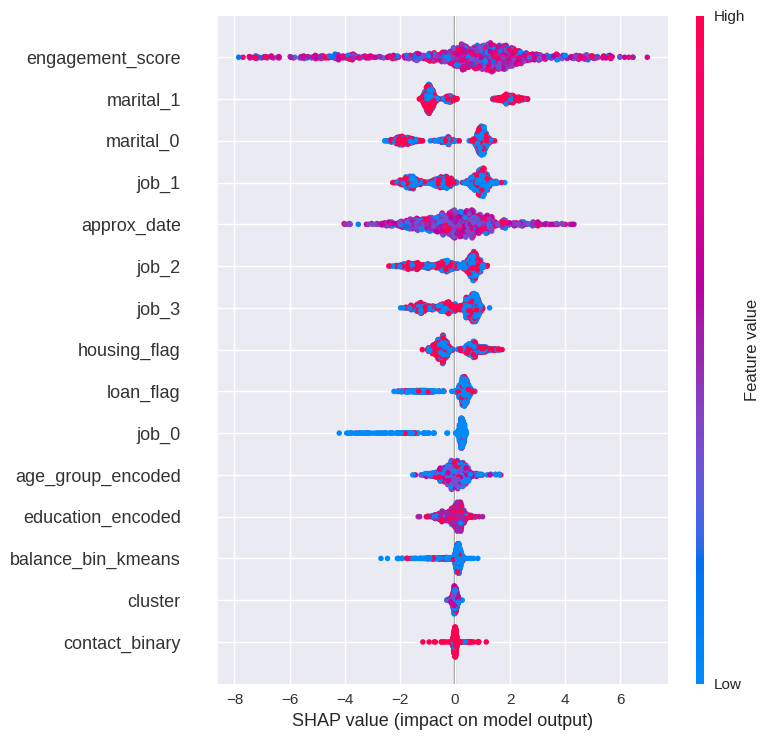

In [ ]:
# ============================================================================
# STEP 8: MODEL INTERPRETABILITY (SHAP) — OPTIONAL
# ============================================================================

if SHAP_AVAILABLE:
    show_header('STEP 8: SHAP INTERPRETABILITY (OPTIONAL)')
    # Choose best single model by test AUC
    best_single = max((k,v) for k,v in best_models.items() if k != 'Ensemble')
    model_name, model_info = best_single
    print('Running SHAP for:', model_name)
    try:
        explainer = shap.Explainer(model_info['model'], X_test)
        shap_values = explainer(X_test.sample(min(1000, len(X_test))))
        shap.summary_plot(shap_values, X_test.sample(min(1000, len(X_test))), show=True)
    except Exception as e:
        print('SHAP analysis failed:', e)
else:
    print('\nSHAP not available — skip interpretability step (install shap to enable).')

In [ ]:
# ============================================================================
# STEP 9: CAMPAIGN OPTIMIZATION (ACTUAL & EXPECTED-PROFIT SELECTION)
# ============================================================================

show_header('STEP 9: CAMPAIGN OPTIMIZATION')

# Business parameters
REVENUE_PER_CONVERSION = 1000
COST_PER_CONTACT = 70
CAMPAIGN_BUDGET = 100000

# Select which model's probabilities to use: choose the best test_auc available
model_for_campaign = max(best_models.keys(), key=lambda k: best_models[k].get('test_auc', -1))
print('Using model for campaign optimization:', model_for_campaign)
probs = best_models[model_for_campaign]['probabilities']


STEP 9: CAMPAIGN OPTIMIZATION

Using model for campaign optimization: Ensemble


In [ ]:
# Build test_customers DataFrame
test_customers = pd.DataFrame({'customer_id': np.arange(len(X_test)),
                               'response_probability': probs,
                               'actual_response': y_test.values})
# quartiles
test_customers['prob_quartile'] = pd.qcut(test_customers['response_probability'], q=4, labels=['Low','Medium','High','Very_High'])

In [ ]:
# Strategy definitions (same as earlier): thresholds + Top10/25/All
probability_thresholds = [0.1,0.2,0.3,0.4,0.5]
strategies = {}
for t in probability_thresholds:
    strategies[f'Prob_>{t:.2f}'] = test_customers[test_customers['response_probability'] > t].copy()
strategies['Target_All'] = test_customers.copy()
strategies['Top_10%'] = test_customers.nlargest(max(1, len(test_customers)//10), 'response_probability').copy()
strategies['Top_25%'] = test_customers.nlargest(max(1, len(test_customers)//4), 'response_probability').copy()

In [ ]:
# Evaluate strategies under budget (actual-response simulation)
strategy_results_actual = {}
max_contactable = CAMPAIGN_BUDGET // COST_PER_CONTACT

for name, customers in strategies.items():
    n_customers = len(customers)
    if n_customers == 0:
        strategy_results_actual[name] = {'customers_contacted':0,'total_cost':0,'actual_conversions':0,'actual_revenue':0,'actual_profit':0,'roi':0,'conversion_rate':0,'avg_probability':0}
        continue
    actual_contact = min(n_customers, int(max_contactable))
    if n_customers > actual_contact:
        selected = customers.nlargest(actual_contact, 'response_probability') # Select top customers with len of actual_contact
    else:
        selected = customers
    total_cost = actual_contact * COST_PER_CONTACT
    actual_conversions = int(selected['actual_response'].sum())
    actual_revenue = actual_conversions * REVENUE_PER_CONVERSION
    actual_profit = actual_revenue - total_cost
    roi = (actual_profit / total_cost) * 100 if total_cost > 0 else 0
    conv_rate = selected['actual_response'].mean() if len(selected)>0 else 0
    strategy_results_actual[name] = {'customers_contacted':actual_contact,'total_cost':total_cost,'actual_conversions':actual_conversions,'actual_revenue':actual_revenue,'actual_profit':actual_profit,'roi':roi,'conversion_rate':conv_rate,'avg_probability':selected['response_probability'].mean() if len(selected)>0 else 0}

strategy_df_actual = pd.DataFrame(strategy_results_actual).T.sort_values('actual_profit', ascending=False)
print('Actual-response simulation results:')
display(strategy_df_actual.round(3))



Actual-response simulation results:


,customers_contacted,total_cost,actual_conversions,actual_revenue,actual_profit,roi,conversion_rate,avg_probability
Prob_>0.10,1428.0,99960.0,604.0,604000.0,504040.0,504.242,0.423,0.745
Prob_>0.20,1428.0,99960.0,604.0,604000.0,504040.0,504.242,0.423,0.745
Prob_>0.30,1428.0,99960.0,604.0,604000.0,504040.0,504.242,0.423,0.745
Prob_>0.40,1428.0,99960.0,604.0,604000.0,504040.0,504.242,0.423,0.745
Target_All,1428.0,99960.0,604.0,604000.0,504040.0,504.242,0.423,0.745
Top_25%,1428.0,99960.0,604.0,604000.0,504040.0,504.242,0.423,0.745
Prob_>0.50,1411.0,98770.0,600.0,600000.0,501230.0,507.472,0.425,0.748
Top_10%,904.0,63280.0,439.0,439000.0,375720.0,593.742,0.486,0.838


In [ ]:
# === Expected-profit selection (greedy knapsack-like) ===
# Since cost per contact is identical for everyone, selecting by expected profit per-customer is optimal.
# expected_profit_i = p_i * REVENUE_PER_CONVERSION - COST_PER_CONTACT

test_customers['expected_profit'] = test_customers['response_probability'] * REVENUE_PER_CONVERSION - COST_PER_CONTACT
# Sort by expected profit descending and pick top until budget exhausted (skip negative expected profits)
candidates = test_customers[test_customers['expected_profit'] > 0].sort_values('expected_profit', ascending=False).copy()
max_contacts = int(CAMPAIGN_BUDGET // COST_PER_CONTACT)
selected_expected = candidates.head(max_contacts)

total_expected_cost = len(selected_expected) * COST_PER_CONTACT
# Expected conversions (sum of probabilities)
expected_conversions = selected_expected['response_probability'].sum()
expected_revenue = expected_conversions * REVENUE_PER_CONVERSION
expected_profit = expected_revenue - total_expected_cost
expected_roi = (expected_profit / total_expected_cost) * 100 if total_expected_cost>0 else 0

print('\nExpected-profit greedy selection summary:')
print(f'  Selected customers: {len(selected_expected)}')
print(f'  Total expected conversions: {expected_conversions:.2f}')
print(f'  Expected revenue: ${expected_revenue:,.2f}')
print(f'  Expected profit: ${expected_profit:,.2f} (ROI {expected_roi:.1f}%)')

# Compare with 'Top_10%' and best actual strategy
best_actual = strategy_df_actual['roi'].idxmax() if len(strategy_df_actual)>0 else None
print('\nBest actual-response strategy (by ROI):', best_actual)

# %% [markdown]
# **Explanation**
# - The *actual-response simulation* uses observed responses in the test set to compute realized conversions and ROI for each strategy under the campaign budget.
# - The *expected-profit* selection ranks customers by `p_i * revenue - cost` and picks the top customers until the budget is exhausted. Since cost per contact is constant, this greedy method is optimal for maximizing expected profit.


Expected-profit greedy selection summary:
  Selected customers: 1428
  Total expected conversions: 1064.33
  Expected revenue: $1,064,334.58
  Expected profit: $964,374.58 (ROI 964.8%)

Best actual-response strategy (by ROI): Top_10%


In [ ]:
# Final summary printout
print('\nFINAL SUMMARY:')
print(f"  Best model for campaign: {model_for_campaign} with Test AUC {best_models[model_for_campaign]['test_auc']:.4f}")
if len(strategy_df_actual)>0:
    print(f"  Recommended strategy (actual-sim): {strategy_df_actual['roi'].idxmax()} | ROI: {strategy_df_actual['roi'].max():.1f}%")
print(f"  Expected-profit greedy selection ROI: {expected_roi:.1f}% | Expected Profit: ${expected_profit:,.0f}")

print('\nCompleted end-to-end notebook for enhanced marketing campaign optimization.')



FINAL SUMMARY:
  Best model for campaign: Ensemble with Test AUC 0.8486
  Recommended strategy (actual-sim): Top_10% | ROI: 593.7%
  Expected-profit greedy selection ROI: 964.8% | Expected Profit: $964,375

Completed end-to-end notebook for enhanced marketing campaign optimization.


In [ ]:
(964375-504040)/504040

0.9132906118562019